In [1]:
# import for data preparation
from pathlib import Path
import requests
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from numpy import random

# import for graphing results
import matplotlib.pyplot as plt
import numpy as np

#### Load and Prepare Data

In [2]:
PATH_DATA = Path("data")
FILENAME_DATA = Path("adele.txt")

# Download dataset
PATH_DATA.mkdir(exist_ok = True)
PATH_DATAFILE = PATH_DATA / FILENAME_DATA

In [3]:
with open(PATH_DATAFILE, 'r', encoding="utf8") as f:
    lines = f.readlines()
    chars = ''.join(lines)
            
print("Sample text:\n")
print(chars[:276])

Sample text:

Looking for some education
Made my way into the night
All that bullshit conversation
Baby, can't you read the signs? I won't bore you with the details, baby
I don't even wanna waste your time
Let's just say that maybe
You could help me ease my mind
I ain't Mr. Right But if yo


In [4]:
print("Total number of chars:", len(chars))
print("Unique chars:", len(set(chars)))

Total number of chars: 91330
Unique chars: 68


In [5]:
# Adapted from https://github.com/pytorch/examples/blob/master/word_language_model/data.py

class Dictionary(object):
    def __init__(self):
        self.char2idx = {}
        self.idx2char = []

    def add_char(self, char):
        if char not in self.char2idx:
            self.idx2char.append(char)
            self.char2idx[char] = len(self.idx2char) - 1
        return self.char2idx[char]

    def __len__(self):
        return len(self.idx2char)


In [6]:
dictionary = Dictionary()
tensor_data = torch.LongTensor(len(chars))

for i, c in enumerate(chars):
    tensor_data[i] = dictionary.add_char(c)
    
n_elements = len(dictionary)

In [7]:
split = round(0.98 * len(tensor_data))
train_data, train_label = tensor_data[:split], tensor_data[1:split+1]
valid_data, valid_label = tensor_data[split:-2], tensor_data[split+1:]


#### Choose a Device

In [8]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, batch_size, rnn_module = "RNN", hidden_size = 64, num_layers = 1, dropout = 0):
        super(Net, self).__init__()
        self.input_size = input_size
        self.rnn_module = rnn_module
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if rnn_module == "RNN":
            self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        elif rnn_module == "LSTM":
            self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        elif rnn_module == "GRU":
            self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
            
        self.output = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        output = input.view(1, -1, self.input_size)
        output, hidden = self.rnn(output, hidden)
        output = self.output(output[0])
        return output, hidden

    def init_hidden(self, batch_size):
        # initialize hidden state to zeros
        if self.rnn_module == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device), 
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size)


#### Training and Evaluation

In [10]:
class train():    
    def __init__(self, train_data, train_label, device, sequence_per_batch = 64, char_per_sequence = 128):
        
        self.train_data = train_data
        self.train_label = train_label
        self.sequence_per_batch = sequence_per_batch
        self.char_per_sequence = char_per_sequence
        self.device = device
        self.length = len(train_data)
        
        # We start reading the text at even sections based on number of sequence per batch
        self.batch_idx = range(0, self.length, self.length // sequence_per_batch)
        self.batch_idx = self.batch_idx[:sequence_per_batch]
        assert len(self.batch_idx) == sequence_per_batch, '{} batches expected vs {} actual'.format(sequence_per_batch,
                                                                                                    len(self.batch_idx))
        
    def next_batch(self):
        
        # loop to the start if we reached the end of text
        self.batch_idx = list(idx if idx + self.char_per_sequence < self.length else 0 for idx in self.batch_idx)
        
        # Extract sequences
        sequences_input = tuple(self.train_data[idx:idx+self.char_per_sequence] for idx in self.batch_idx)
        sequences_label = tuple(self.train_label[idx:idx+self.char_per_sequence] for idx in self.batch_idx)

        # Transform input into one-hot (source: https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/29)
        sequences_input = tuple(torch.zeros(len(data), n_elements, device = self.device).scatter_(1, data.unsqueeze(-1), 1) for data in sequences_input)
        
        # Move next idx
        self.batch_idx = (idx + self.char_per_sequence for idx in self.batch_idx)
        
        # Concatenate tensors
        return torch.stack(sequences_input, dim=1), torch.stack(sequences_label, dim=1)


#### Training Step

In [11]:
# Hyper-parameters
rnn_module = "LSTM"
hidden_size = 128
num_layers = 4
dropout = 0.1
epochs = 20
batches_per_epoch = 300
sequence_per_batch = 10
char_per_sequence = 50

In [12]:
# Build the NN
net = Net(n_elements, sequence_per_batch, rnn_module, hidden_size, num_layers, dropout)
hidden = net.init_hidden(sequence_per_batch)

# Use GPU if available
train_data = train_data.to(device)
train_label = train_label.to(device)
valid_data = valid_data.to(device)
valid_label = valid_label.to(device)
net.to(device)
if rnn_module == "LSTM":
    for h in hidden:
        h = h.to(device)
else:
    hidden = hidden.to(device)


In [13]:
# Define optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam
optimizer = optimizer_function(net.parameters())

# Load data
training_data = train(train_data, train_label, device, sequence_per_batch, char_per_sequence)
valid_length = len(valid_data)

train_losses = []
valid_losses = []

for epoch in trange(epochs):
    train_loss = 0   # training loss
    valid_loss = 0   # validation loss
    
    # Training of one epoch
    net.train()
    for i in trange(batches_per_epoch):
        
        # Get a batch of sequences
        input_vals, label_vals = training_data.next_batch()

        # Detach hidden layer and reset gradients
        if rnn_module == "LSTM":
            tuple(h.detach_() for h in hidden)
        else:
            hidden.detach_()
        optimizer.zero_grad()
        
        # Forward pass and calculate loss
        loss_sequence = torch.zeros(1, device=device)
        for (input_val, label_val) in zip(input_vals, label_vals):
            input_val = input_val.to(device) # change moving input tensor to device
            output, hidden = net(input_val, hidden)
            loss = loss_function(output, label_val.view(-1))
            loss_sequence += loss
            
        # Backward propagation and weight update
        loss_sequence.backward()
        optimizer.step()
                
        train_loss += loss_sequence.item() / batches_per_epoch / char_per_sequence
        
    # Calculate validation loss
    with torch.no_grad():
        net.eval()
        
        # Detach hidden layers
        hidden_valid = net.init_hidden(1) #.to(device) # change hidden layer to device
        if rnn_module == "LSTM":
            for h in hidden_valid:
                h = h.to(device)
        else:
            hidden_valid = hidden_valid.to(device)
            
        # Process validation data one character at a time
        for i in range(valid_length-1):
            input_val = valid_data[i].view(1)
            label_val = valid_label[i]

            # One-hot input
            input_val = torch.zeros(len(input_val), n_elements, device = device).scatter_(1, input_val.unsqueeze(-1), 1)
            input_val = input_val.to(device) # move input tensor to device

            # Forward pass and calculate loss
            output, hidden_valid = net(input_val, hidden_valid)
            loss = loss_function(output, label_val.view(-1))
            valid_loss += loss.item() / (valid_length - 1)
            
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print("Epoch {} - Training loss {} - Validation loss {}".format(epoch+1, train_loss, valid_loss))


  5%|▌         | 1/20 [00:35<11:08, 35.16s/it]

Epoch 1 - Training loss 3.142394819132488 - Validation loss 3.3532969373229333



 10%|█         | 2/20 [01:10<10:31, 35.08s/it]

Epoch 2 - Training loss 3.110024643961589 - Validation loss 3.339656869439704



 15%|█▌        | 3/20 [01:44<09:53, 34.92s/it]

Epoch 3 - Training loss 2.846330195617675 - Validation loss 2.857550070441345



 20%|██        | 4/20 [02:19<09:19, 34.98s/it]

Epoch 4 - Training loss 2.395310365295412 - Validation loss 2.733660605049844



 25%|██▌       | 5/20 [02:55<08:45, 35.02s/it]

Epoch 5 - Training loss 2.2813012852986647 - Validation loss 2.637085057950265



 30%|███       | 6/20 [03:30<08:10, 35.04s/it]

Epoch 6 - Training loss 2.1792619313557946 - Validation loss 2.507899496814627



 35%|███▌      | 7/20 [04:05<07:35, 35.05s/it]

Epoch 7 - Training loss 2.0778239934285474 - Validation loss 2.488319056758071



 40%|████      | 8/20 [04:40<07:01, 35.09s/it]

Epoch 8 - Training loss 2.018494561258954 - Validation loss 2.4363541031713822



 45%|████▌     | 9/20 [05:15<06:26, 35.11s/it]

Epoch 9 - Training loss 1.9598335795084625 - Validation loss 2.3799280720291054



 50%|█████     | 10/20 [05:50<05:51, 35.11s/it]

Epoch 10 - Training loss 1.8957092142740892 - Validation loss 2.3665862885066855



 55%|█████▌    | 11/20 [06:25<05:16, 35.13s/it]

Epoch 11 - Training loss 1.8549119201660158 - Validation loss 2.3590586282621273



 60%|██████    | 12/20 [07:00<04:39, 34.95s/it]

Epoch 12 - Training loss 1.8102708002726238 - Validation loss 2.2755737872830055



 65%|██████▌   | 13/20 [07:35<04:05, 35.02s/it]

Epoch 13 - Training loss 1.7535284784952803 - Validation loss 2.283999580852542



 70%|███████   | 14/20 [08:10<03:29, 34.90s/it]

Epoch 14 - Training loss 1.719754552205404 - Validation loss 2.304775423669762



 75%|███████▌  | 15/20 [08:44<02:53, 34.80s/it]

Epoch 15 - Training loss 1.6842126800537103 - Validation loss 2.2267526870679184



 80%|████████  | 16/20 [09:19<02:19, 34.87s/it]

Epoch 16 - Training loss 1.6357561915079741 - Validation loss 2.233139375179904



 85%|████████▌ | 17/20 [09:55<01:45, 35.15s/it]

Epoch 17 - Training loss 1.6072989349365236 - Validation loss 2.262361050182867



 90%|█████████ | 18/20 [10:30<01:10, 35.12s/it]

Epoch 18 - Training loss 1.5762077901204428 - Validation loss 2.1853480783698105



 95%|█████████▌| 19/20 [11:05<00:35, 35.16s/it]

Epoch 19 - Training loss 1.5371262847900382 - Validation loss 2.179049206330729



100%|██████████| 20/20 [11:41<00:00, 35.05s/it]

Epoch 20 - Training loss 1.510996245829264 - Validation loss 2.251847357501679


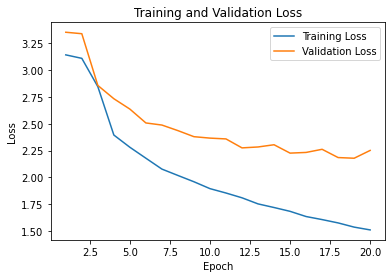

In [14]:
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Save model
PATH_MODEL = "model.pt"
torch.save(net, PATH_MODEL)
print("Model saved")

Model saved


In [16]:
# Load model
PATH_MODEL = "model.pt"
net = torch.load(PATH_MODEL)

# Move model to CPU
net = net.to(torch.device("cpu"))

#### Evaluation Step

In [17]:
with torch.no_grad():
    
    # Go into evaluation mode
    net.eval()
    
    # Define a sequence of characters to initialize the hidden states
    init_chars = "He "

    init_data = torch.LongTensor(len(init_chars))
    for i, c in enumerate(init_chars):
        init_data[i] = dictionary.char2idx[c]

    # Transform into one-hot
    init_data = torch.zeros(len(init_data), n_elements).scatter_(1, init_data.unsqueeze(-1), 1)

    # Initialize hidden layer and feed sequence of characters to the model
    hidden = net.init_hidden(1)
    hidden = tuple(h.to(torch.device("cpu")) for h in hidden) # move hidden to same device
    for init_char in init_data:
        output, hidden = net(init_char, hidden)

    # Predict next characters one at a time
    number_chars = 1000
    chars = init_chars
    for _ in range(number_chars):

        # Calculate probability distribution of outputs with a temperature of 0.5
        prob = nn.Softmax(1)(output/0.5).squeeze().cpu().numpy()

        # Sample from outputs
        output_idx = random.choice(len(prob), p = prob)

        # Extract predicted char
        predicted_char = dictionary.idx2char[output_idx]
        chars += predicted_char

        # Transform predicted char into one-hot vector
        output_idx = torch.LongTensor([[output_idx]])
        next_input = torch.zeros(len(output_idx), n_elements).scatter_(1, output_idx, 1)

        # Feed into NN to predict next char
        output, hidden = net(next_input, hidden)

    # Print predicted sequence
    print("Initializing sequence:", init_chars)
    print("Predicted sequence:\n", chars)    


Initializing sequence: He 
Predicted sequence:
 He the lagkthed want you to tear it all the day it love the Ready the Raeld I feel me
I love to be be me the ristt
We were my heart the will the way and fake you that I wall you to be the that I want you the dinding and the find the light you never me in my have me I were the ready awain all I want the dart
And you let you want the ready love always I want the things the way you say your love to you
And say you
You slart
We want you don't see and down
I want the starts a fire my heart a wisht a showe the worded the realle I can't let go back the stirk the was it all the say in the way it eass me are the light it our it bake you to you
When we was it I want you fall
I'm stayin the love to your blearh to the stard the start
I was it all the dinder it all
It's the ready that want in that I could be do love to you
I say all the sky I was let and lear the stirked you want you're rade the mind
I son't want the same you do you
I want will to the